In [1]:
import sys
sys.path.append("..")

from datetime import datetime
import numpy as np
import ujson as json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from lib.dataclasses import SignalDCT, SignalTime, SingleSample, Sample, SignalSpectrum
from lib.utils import get_sample_from_json
from copy import deepcopy

In [2]:
plt.style.use('ggplot')
from matplotlib.gridspec import GridSpec

Variables

In [3]:
PATH_TO_DATASET_1 = "/workspaces/project/raw/sequence_1/"
PATH_TO_DATASET_2 = "/workspaces/project/raw/sequence_2/"

# Importing data

In [4]:
valid_date = datetime(2023, 1, 7, 10, 00)

sample_list = []
for file_path in tqdm(os.listdir(PATH_TO_DATASET_2)):
    sample_id = file_path.split(".json")[0]
    date = datetime.strptime(sample_id, "%Y_%m_%d_%H_%M")
    if date >= valid_date:
        sample = get_sample_from_json(
            path = PATH_TO_DATASET_2 + file_path,
            sample_id=sample_id
        )
        sample_list.append(sample)

100%|██████████| 4420/4420 [01:22<00:00, 53.86it/s]


In [5]:
def get_rms(x: list):
    return np.sqrt((x**2).mean())

time_sample = deepcopy(sample_list[10])
time_sample.convert_to_time()

In [6]:
def get_band_data(x:list, window:int, fun:str="mean") -> list:
    N = len(x)
    assert N % window == 0

    functions = {
        "mean": lambda x: x.mean(axis=1),
        "max": lambda x: x.max(axis=1),
        "min": lambda x: x.min(axis=1),
        "abs-mean": lambda x: np.abs(x).mean(axis=1),
        "abs-median": lambda x: np.median(np.abs(x), axis=1)
    }

    x = np.array(x)
    x = x.reshape(-1, window)
    x = functions[fun](x)
    return list(x)


In [7]:
tensions = [sample.sample_c1.tension for sample in sample_list]
dates = [sample.sampled_at for sample in sample_list]

dct_per_cable = []
for cable in [0,1,2,3]:
    dct_per_cable.append({d: np.array([get_band_data(sample[cable][d].get()[1], window=64, fun="abs-mean") for sample in sample_list]) for d in ["x","y","z"]})

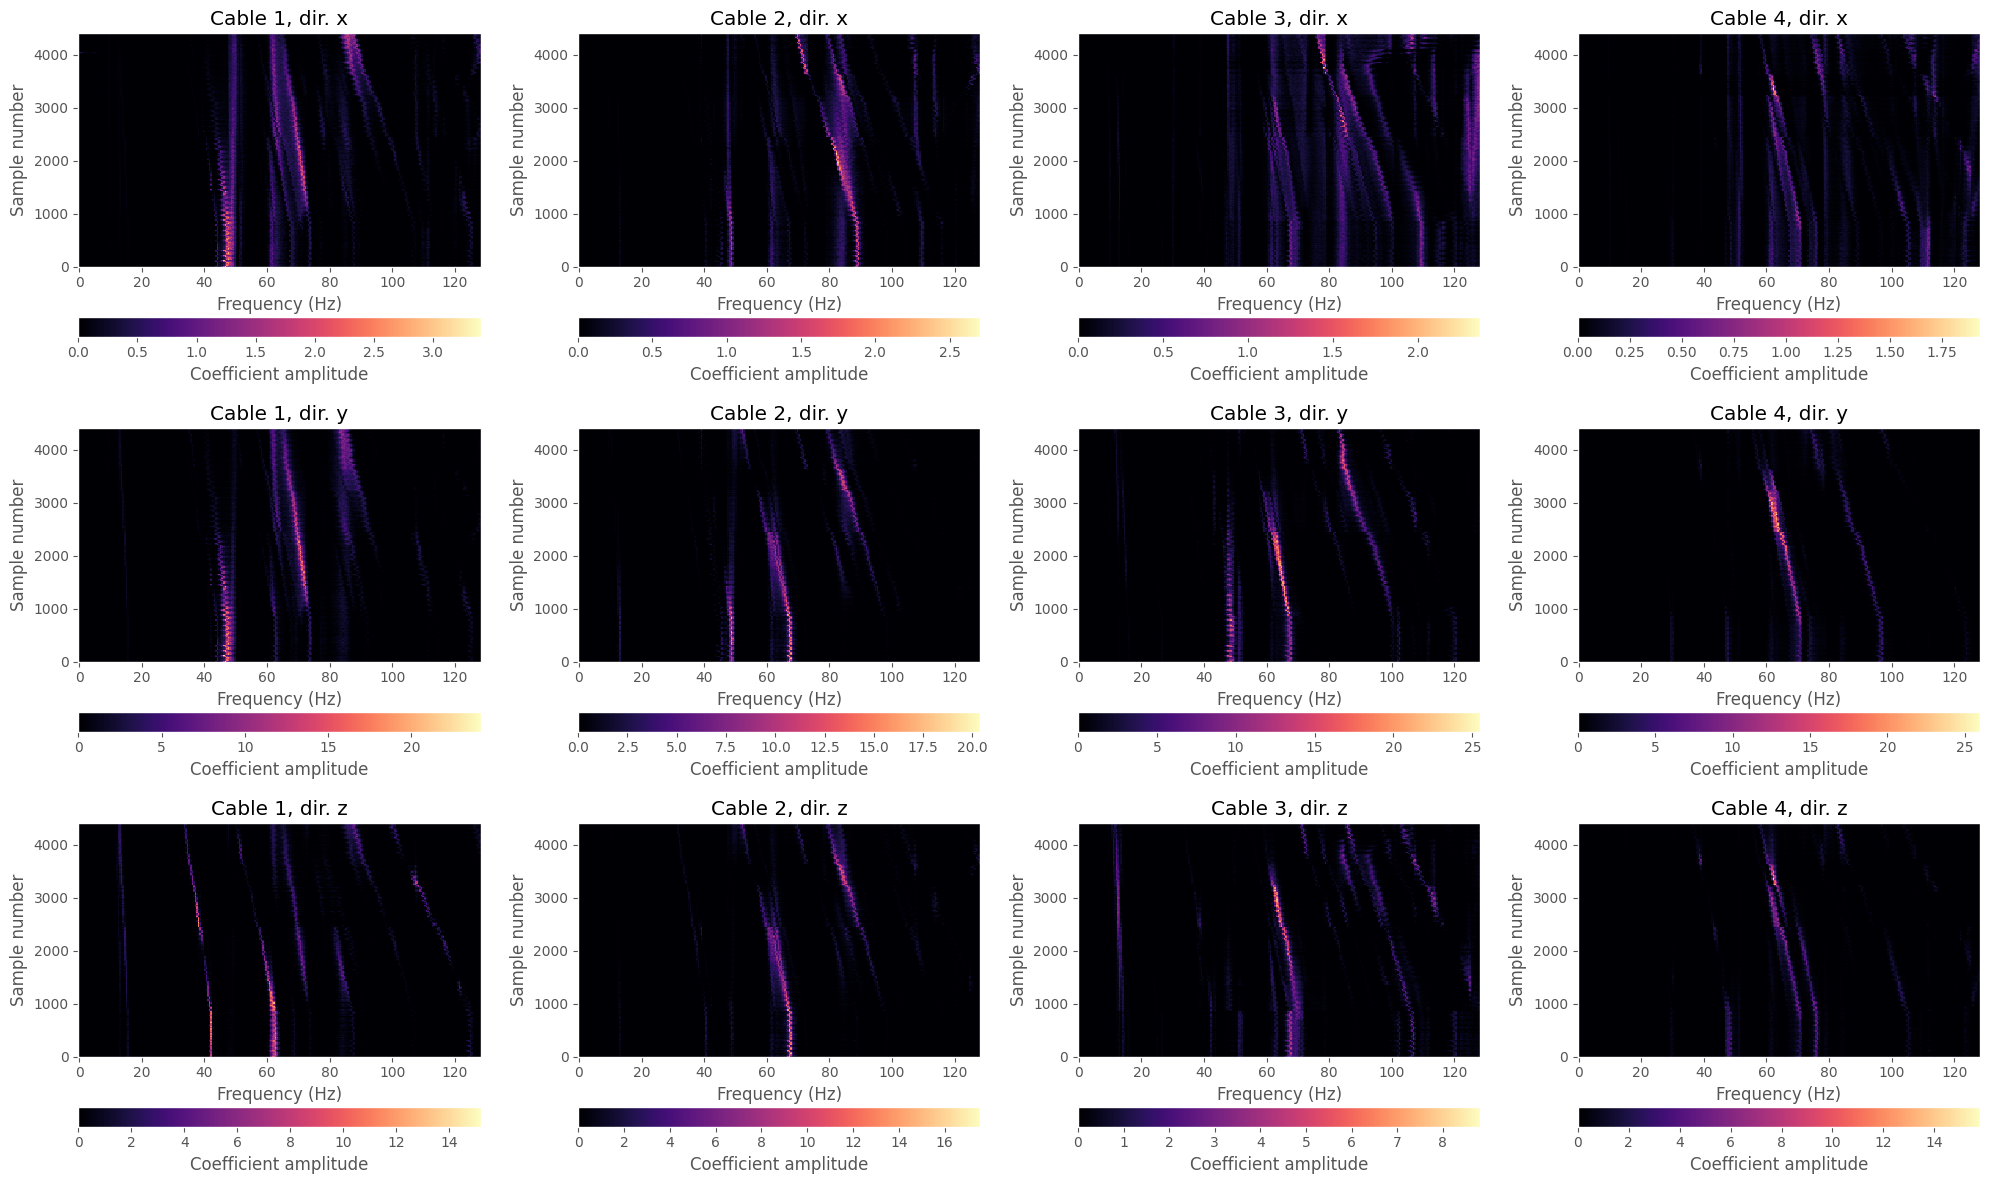

In [8]:
min_x = 0
max_x = len(tensions)

f = np.linspace(0, 128, dct_per_cable[0]["x"].shape[1])
t = np.linspace(0, dct_per_cable[0]["x"].shape[0], dct_per_cable[0]["x"].shape[0])

fig = plt.figure(figsize=(20,12))
cont = 1
for d in ["x","y","z"]:
    for cable in [0,1,2,3]:
        ax = fig.add_subplot(3, 4, cont)
        ax.set_title(f"Cable {cable+1}, dir. {d}")
        pc = ax.pcolormesh(f, t, np.abs(dct_per_cable[cable][d]), cmap="magma")
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Sample number")
        fig.colorbar(pc, location="bottom", label="Coefficient amplitude")
        cont += 1

fig.tight_layout()

In [9]:
en_per_cable = {}

for cable in [0,1,2,3]:
    en_per_cable[cable] = {d: [sample[cable][d].get_energy() for sample in sample_list] for d in ["x","y","z"]}

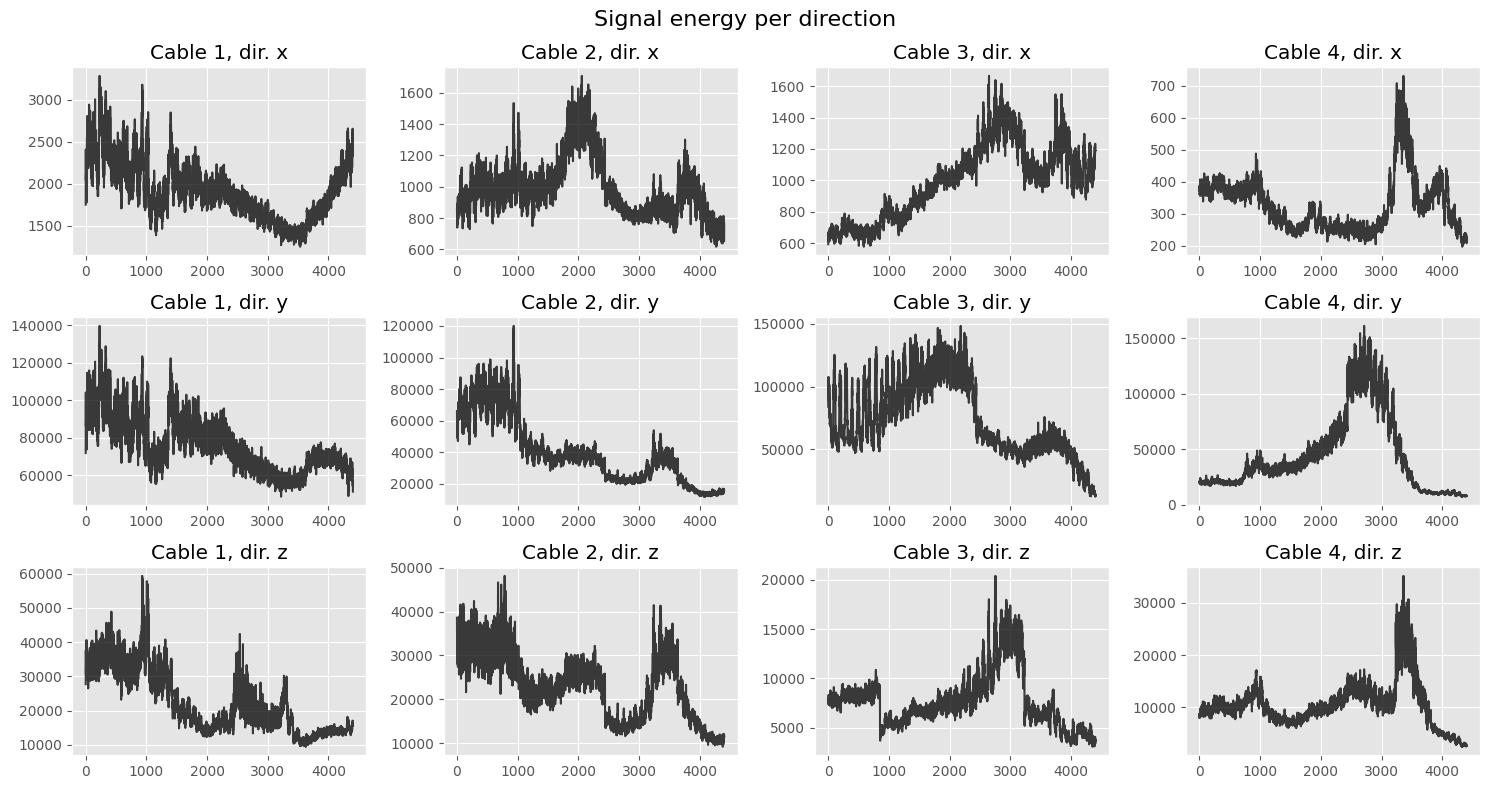

In [10]:
fig = plt.figure(figsize=(15,8))
cont = 1
for d in ["x","y","z"]:
    fig.suptitle("Signal energy per direction", fontsize=16)
    for cable in [0,1,2,3]:
        ax = fig.add_subplot(3, 4, cont)
        ax.set_title(f"Cable {cable+1}, dir. {d}")
        ax.plot(en_per_cable[cable][d], color="k", alpha=0.75)
        cont += 1
    fig.tight_layout()

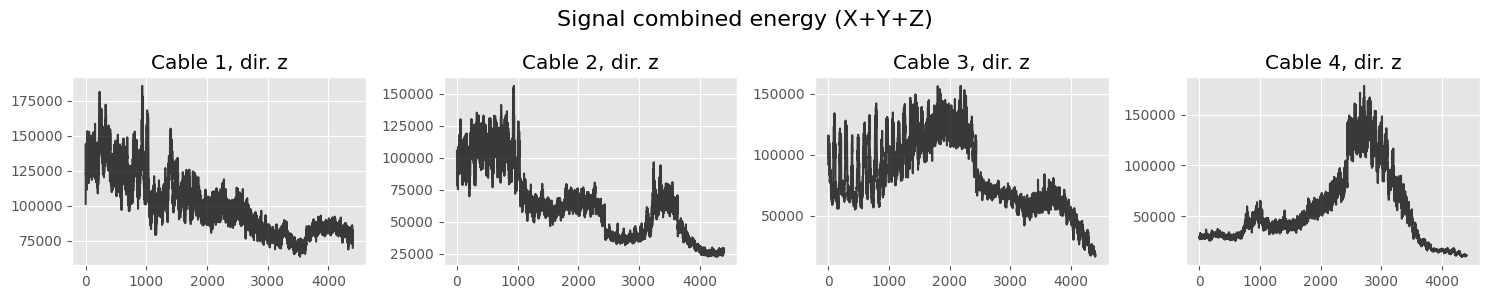

In [11]:
fig = plt.figure(figsize=(15,3))
cont = 1
fig.suptitle("Signal combined energy (X+Y+Z)", fontsize=16)
for cable in [0,1,2,3]:
    ax = fig.add_subplot(1, 4, cont)
    ax.set_title(f"Cable {cable+1}, dir. {d}")
    combined_energy = np.array([en_per_cable[cable][d] for d in ["x","y","z"]]).sum(axis=0)
    ax.plot(combined_energy, color="k", alpha=0.75)
    cont += 1
fig.tight_layout()

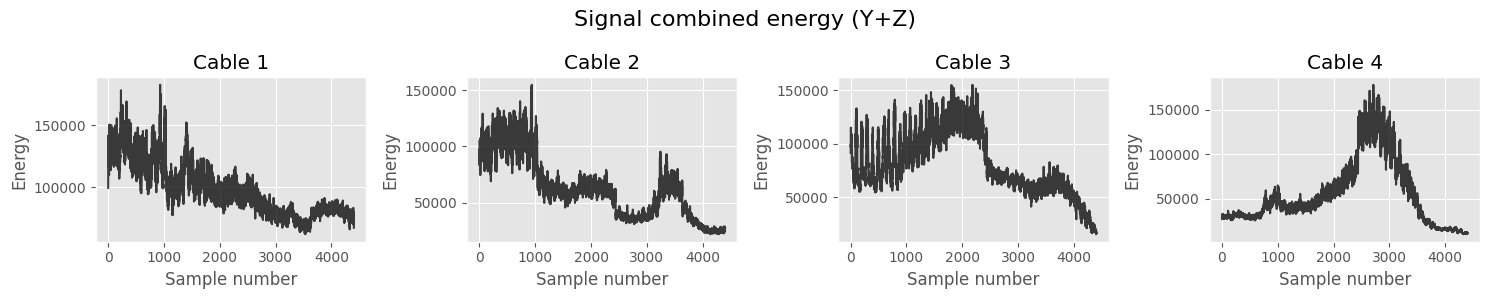

In [12]:
fig = plt.figure(figsize=(15,3))
cont = 1
fig.suptitle("Signal combined energy (Y+Z)", fontsize=16)
for cable in [0,1,2,3]:
    ax = fig.add_subplot(1, 4, cont)
    ax.set_title(f"Cable {cable+1}")
    combined_energy = np.array([en_per_cable[cable][d] for d in ["y","z"]]).sum(axis=0)
    ax.plot(combined_energy, color="k", alpha=0.75)
    ax.set_xlabel("Sample number")
    ax.set_ylabel("Energy")
    cont += 1
fig.tight_layout()

Identifying interesting bands

In [13]:
def get_mean_coef_per_cable(sample_list: list, cable: int) -> np.ndarray:
    coef_per_cable = []

    for sample in sample_list:
        coef_per_dir = [sample[cable][d].get()[1] for d in ["x", "y", "z"]]
        coef_per_cable.append(np.array(np.abs(coef_per_dir)).sum(axis=0))
    mean_coef_per_cable = np.array(coef_per_cable).mean(axis=0)
    del(coef_per_cable)
    return mean_coef_per_cable

In [14]:
band_limits = [
    0,
    5,
    20,
    32,
    40,
    55,
    75,
    100,
    120,
    128
]

Energy per frequency band

In [15]:
band_pairs = [(band_limits[i], band_limits[i+1]) for i in range(len(band_limits)-1)]

In [16]:
band_matrices = {}

for cable in range(4):
    for d in ["x", "y", "z"]:
        band_matrix = np.zeros((len(sample_list), len(band_pairs)))
        for j, pair in enumerate(band_pairs):
            band_matrix[:,j] = [sample[cable][d].get_energy([pair[0], pair[1]]) for sample in sample_list]
        band_matrices[f"{cable}_{d}"] = band_matrix

In [17]:
band_matrices.keys()

dict_keys(['0_x', '0_y', '0_z', '1_x', '1_y', '1_z', '2_x', '2_y', '2_z', '3_x', '3_y', '3_z'])

y/z-combined 

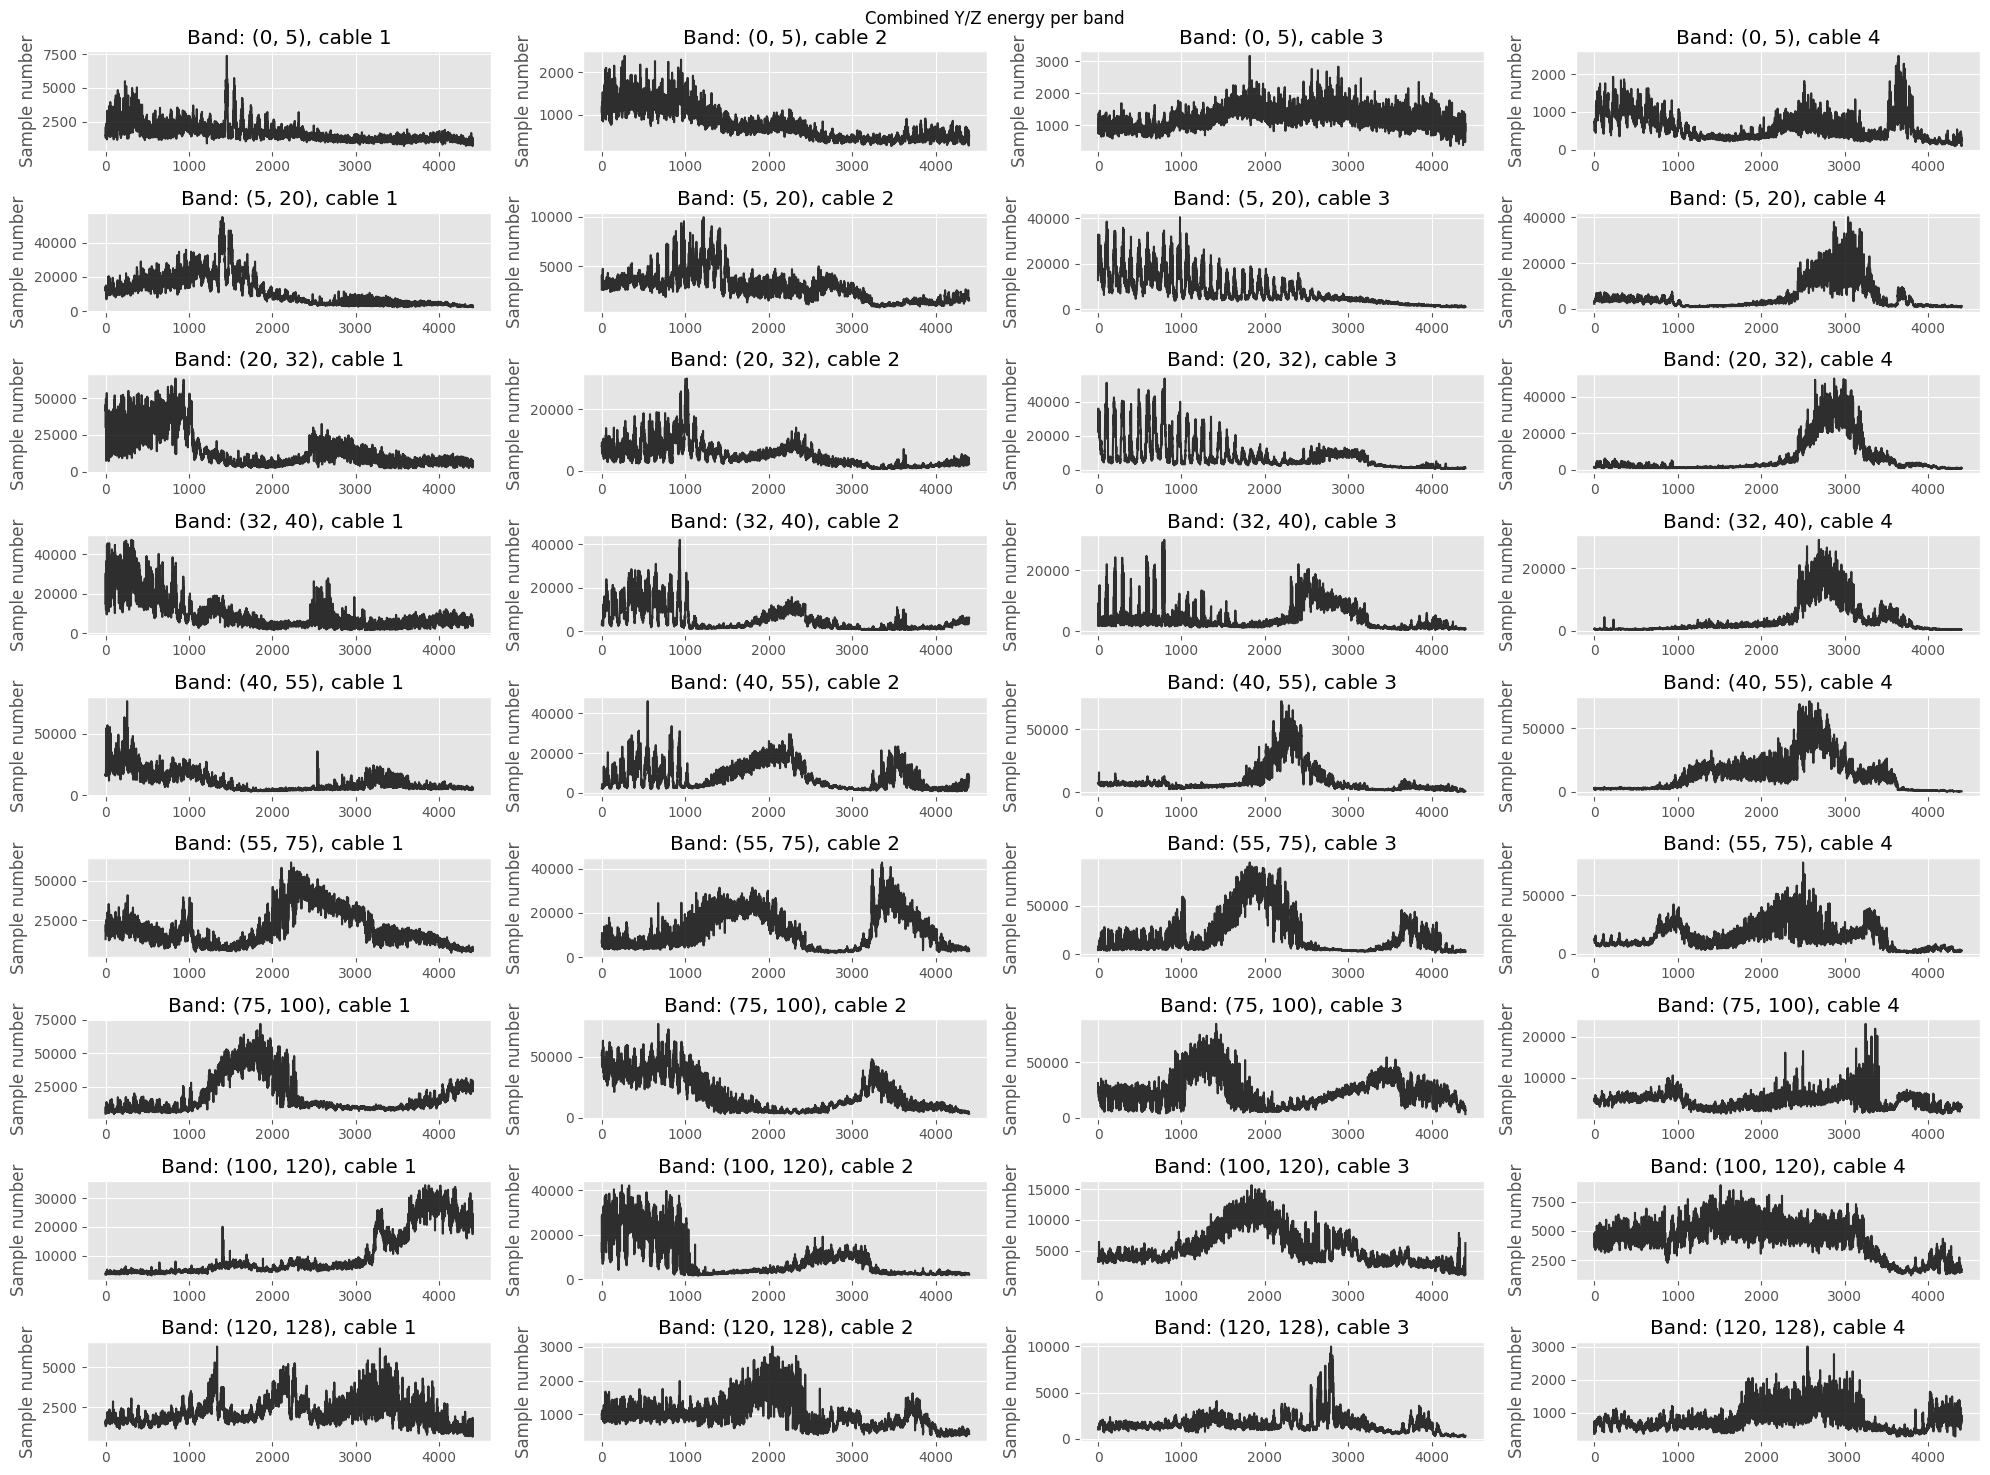

In [18]:
plt.figure(figsize=(20,15))
plt.suptitle("Combined Y/Z energy per band")

spec = GridSpec(
    ncols=4, nrows=9,
)

for cable in range(4):
    combined = band_matrices[f"{cable}_y"] + band_matrices[f"{cable}_z"]
    for n, band_energy in enumerate(combined.T):
        plt.subplot(spec[n, cable])
        plt.title(f"Band: {band_pairs[n]}, cable {cable+1}")
        plt.plot(band_energy, color="k", alpha=0.8)
        plt.ylabel("Energy")
        plt.ylabel("Sample number")
plt.tight_layout()

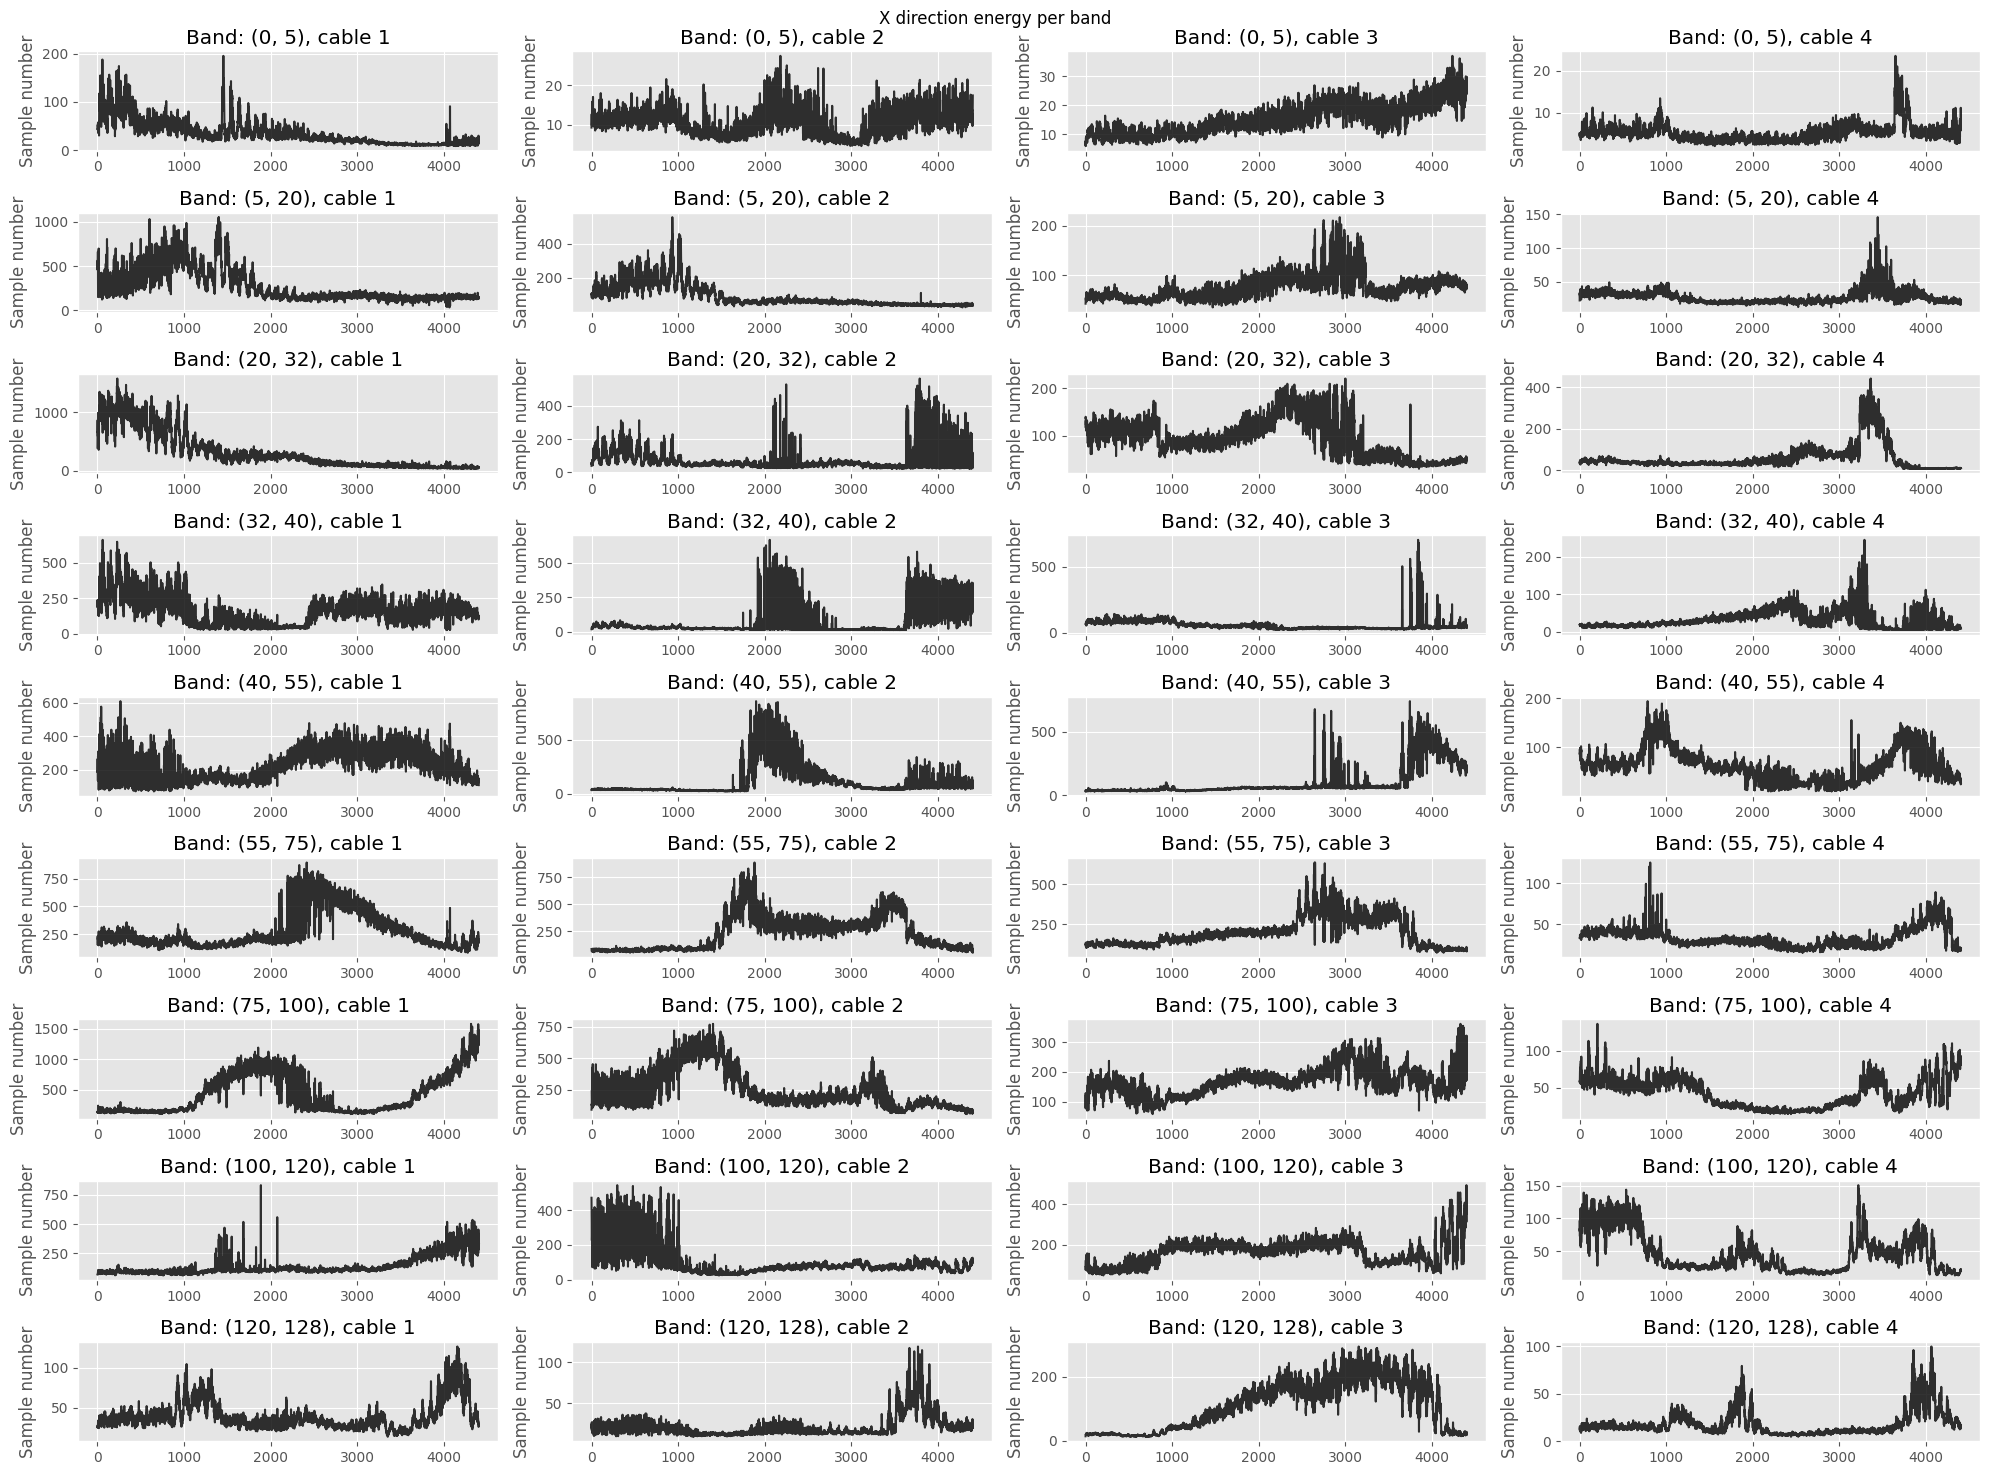

In [19]:
plt.figure(figsize=(20,15))
plt.suptitle("X direction energy per band")

spec = GridSpec(
    ncols=4, nrows=9,
)

for cable in range(4):
    combined = band_matrices[f"{cable}_x"]
    for n, band_energy in enumerate(combined.T):
        plt.subplot(spec[n, cable])
        plt.title(f"Band: {band_pairs[n]}, cable {cable+1}")
        plt.plot(band_energy, color="k", alpha=0.8)
        plt.ylabel("Energy")
        plt.ylabel("Sample number")
plt.tight_layout()